pydlem prep Package Example

In [1]:
import os
from pathlib import Path
import sqlite3
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np


pydlem_dir = r'C:\Users\CNB968\OneDrive - MT\GitHub\pydlem'
os.chdir(pydlem_dir)

from prep.datafile import CreateInputFile
from prep.lakegeom import area_from_eac_curve
from prep.lakegeom import calc_lake_depth
from prep.lakegeom import calc_fetch_length
from prep.metdata import calculate_vpd

Initializing pydlem.prep module.


In [3]:
## Load netcdf from file and create datafile
nc_path = Path(r'C:\Users\CNB968\OneDrive - MT\GitHub\pydlem\examples\Tongue_R\met_datafile_ex.nc')
mod_db_path = Path(r'C:\Users\CNB968\OneDrive - MT\Modeling\Riverware\Models\Tongue River\TRWMM.db')
conn = sqlite3.connect(mod_db_path)
sql = 'SELECT * FROM ReservoirData WHERE FID BETWEEN ? AND ?'
resdata = pd.read_sql(sql, conn, params=(56, 60))
eac_curves = pd.read_sql("SELECT * FROM ReservoirEACs WHERE FID BETWEEN ? AND ?", conn, params=(56, 60))
conn.close()
ex_dset = xr.open_dataset(nc_path)
sdset = ex_dset.sel(location=['71772129', '71759808', '71818121', '120031076', '71772901'])

In [4]:
# Need to rebuild SQLite Database so that nhd_id's are included in all tables
# this is a hack to fix this
nhd = eac_curves['nhd_id'].unique()
fid = eac_curves['FID'].unique()
resdata['nhd_id'] = pd.NA
for i in range(len(fid)):
    resdata.loc[resdata['FID'] == fid[i], 'nhd_id'] = nhd[i]
resdata['datetime'] = pd.to_datetime(resdata['datetime'], format='%Y-%m-%d %H:%M:%S')
resdata = resdata.set_index(['datetime', 'nhd_id'])
resdata

,,Storage_acreft,Elevation_ft,siteID,FID
datetime,nhd_id,,,,
2016-11-08,71772901,NaN,NaN,0204BHR01,56
2016-11-09,71772901,1066.442643,8722.566354,0204BHR01,56
2016-11-10,71772901,1079.059162,8722.738750,0204BHR01,56
2016-11-11,71772901,1104.741298,8722.897083,0204BHR01,56
2016-11-12,71772901,1131.034072,8723.061146,0204BHR01,56
...,...,...,...,...,...
2024-02-20,71818121,NaN,NaN,0204SR01,60
2024-02-21,71818121,NaN,NaN,0204SR01,60
2024-02-22,71818121,NaN,NaN,0204SR01,60


In [5]:
# calculate lake Area
resids = resdata.index.unique(level='nhd_id')
Alst = []
for i in resids:
    curve = eac_curves.loc[eac_curves['nhd_id'] == i].iloc[:, 0:3]
    indat = resdata.xs(i, level='nhd_id', drop_level=False)['Storage_acreft']
    lakeA = area_from_eac_curve(indat, curve)
    Alst.append(lakeA)
LA = pd.concat(Alst) # area is in acres from these curves
LAkm = LA / 247.105  # convert to km^2

<Axes: xlabel='datetime'>

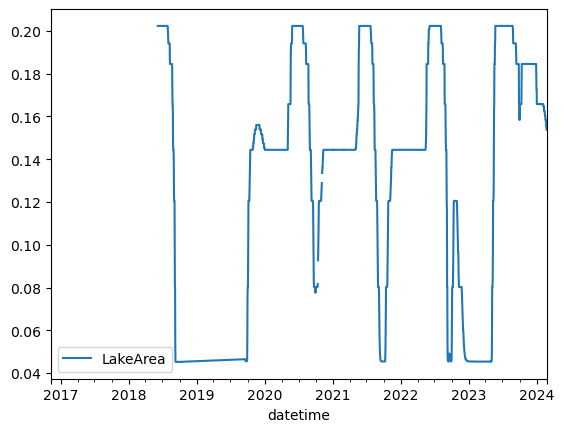

In [6]:
# Plot to test success of area_from_eac_curve() function
LAkm.xs('120031076', level='nhd_id').plot()


<Axes: xlabel='datetime'>

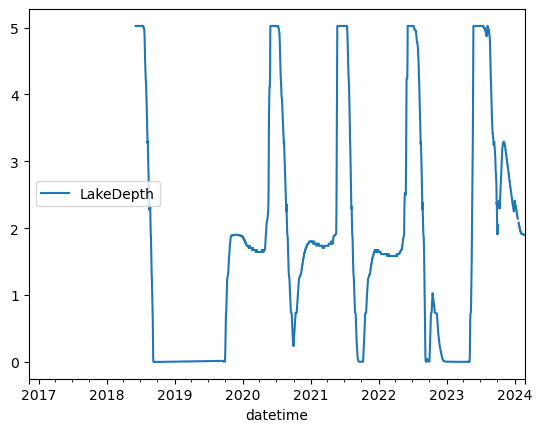

In [7]:
# Calculate daily average lake depth
Ldep = calc_lake_depth(LA['LakeArea'], resdata['Storage_acreft']) # returns feet in this case
Ldepm = Ldep * 0.3048  # convert to meters
# Test Plot for calc_lake_depth() function
Ldepm.xs('120031076', level='nhd_id').plot()

In [8]:
# Calculate VPD (for this example, from Relative Humidity)
VPD = calculate_vpd(Tmin=sdset.min_temp.values - 273.15, # converted to Celcius
                    Tmax=sdset.max_temp.values - 273.15, # converted to Celcius
                    RHmin=sdset.min_rh.values,
                    RHmax=sdset.max_rh.values,
                    method='RHminmax')
VPD = xr.DataArray(VPD, coords=sdset.coords, attrs={'standard_name': 'Vapor Pressure Deficit', 'units': 'kPA'})

In [9]:
# Test the CreateInputFile Class
dfile = CreateInputFile(coords=None, lake_area=LAkm, lake_depth=Ldepm, met_data=sdset, met_source='from_file')
dfile.add_variable(VPD, "vpd")

Variable LakeArea loaded.
Variable LakeArea did not need renaming.
New variable added.
Variable LakeDepth loaded.
Variable LakeDepth did not need renaming.
New variable added.
New variable added.


In [10]:
# Test fetch length function calcs
# have to loop through site and timestamp because of geomoetry consideration, each rotation of the input lake geometry is unique to the daily wind direction,
#   geopandas only applies 1 constant rotation to all geometries in a GeoDataFrame.
# 
# get geometries (polygons) from Spatilite database - COULD PROBABLY MIGRATE TO pynhd?? Avoid on disk access??

# add spatialite to path variable
spatialite_pth = 'C:/Users/CNB968/Spatialite'
os.environ['PATH'] = spatialite_pth + ';' + os.environ['PATH']
# connect to sqlite db and enable spatialite
conn = sqlite3.connect(r'C:\Users\CNB968\OneDrive - MT\Tongue River\RSM Data\Reservoir_Data\reservoirs_test.sqlite')
conn.enable_load_extension(True)
conn.load_extension("mod_spatialite")
# Query reservoir locations from polygon centroids
sql = "SELECT permanent_, AsBinary(Geometry) AS geom FROM reservoirs;"
resvs = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geom')
conn.close()
resvs = resvs.set_crs('4326')
resvs = resvs.to_crs(resvs.estimate_utm_crs())

In [39]:
#gmtry = resvs.loc[resvs['permanent_'] == loc]
gmtry = resvs['geom'].loc[resvs['permanent_'] == '71818121']
rot = gmtry.rotate(276)
w = rot.bounds.maxx.values[0] - rot.bounds.minx.values[0]
w

682.8973013162613

In [58]:
# Loop through data arrays of wind direction and
rows = dfile.data.wind_dir.shape[0]
cols = dfile.data.wind_dir.shape[1]
wnd_d = dfile.data.wind_dir.values
lk_A = dfile.data.LakeArea.values * 1000.0**2
xs = []
for x in range(0, rows):
    ys = []
    for y in range(0, cols):
        gmtry = resvs['geom'].loc[resvs['permanent_'] == dfile.data.location[y].item()]
        wnd = wnd_d[x, y]
        A = lk_A[x, y]
        ftchL = calc_fetch_length(gmtry, wnd, A)
        ys.append(ftchL)
    xs.append(ys)

In [63]:
flen = np.array(xs)
flen = xr.DataArray(flen, coords=sdset.coords, attrs={'standard_name': 'Wind Fetch Length', 'units': 'm'})
dfile.add_variable(flen, 'ftch_len')


New variable added.


In [26]:
t = dfile.data.wind_dir.values
xs = []
for x in range(0, t.shape[0]):
    ys = []
    for y in range(0, t.shape[1]):
        ys.append(t[x, y])
    xs.append(ys)

In [65]:
dfile.save_datafile('examples/tr2100_test_datafile.nc')

In [11]:
dfile.data

<xarray.Dataset>
Dimensions:    (location: 5, time: 16593)
Coordinates:
  * location   (location) object '120031076' '71759808' ... '71818121'
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2024-06-05
    lat        (location) float64 44.5 44.59 44.56 44.53 44.63
    lon        (location) float64 -107.2 -107.3 -107.2 -107.2 -107.3
    elev       (location) float64 2.746e+03 2.659e+03 ... 2.664e+03 2.504e+03
Data variables:
    precip     (time, location) float32 ...
    min_temp   (time, location) float32 240.2 240.8 240.8 ... 276.0 276.0 276.0
    max_temp   (time, location) float32 252.4 252.2 252.2 ... 287.7 287.7 287.7
    solrad     (time, location) float32 ...
    min_rh     (time, location) float32 47.6 46.5 46.5 46.5 ... 39.0 39.0 39.0
    max_rh     (time, location) float32 77.1 74.7 74.7 74.7 ... 80.5 80.5 80.5
    wind_dir   (time, location) float32 ...
    wind_vel   (time, location) float32 ...
    LakeArea   (time, location) float64 nan nan nan nan nan ... nan nan nan nan
    LakeDepth  (time, location) float64 nan nan nan nan nan ... nan nan nan nan
    vpd        (time, location) float32 0.0349 0.03575 0.03575 ... 0.5784 0.5784
Attributes:
    featureType:  timeSeries

In [30]:
LAkm.index.names = ['time', 'location']
LAkm.columns = ['LakeArea']
M = xr.merge([sdset, LAkm.to_xarray()])
M['LakeArea'].attrs = {'standard_name': 'Lake Surface Area', 'units': 'km^2'}
M

<xarray.Dataset>
Dimensions:   (location: 5, time: 16593)
Coordinates:
  * location  (location) object '120031076' '71759808' ... '71772901' '71818121'
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2024-06-05
    lat       (location) float64 44.5 44.59 44.56 44.53 44.63
    lon       (location) float64 -107.2 -107.3 -107.2 -107.2 -107.3
    elev      (location) float64 2.746e+03 2.659e+03 ... 2.664e+03 2.504e+03
Data variables:
    precip    (time, location) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    min_temp  (time, location) float32 240.2 240.8 240.8 ... 276.0 276.0 276.0
    max_temp  (time, location) float32 252.4 252.2 252.2 ... 287.7 287.7 287.7
    solrad    (time, location) float32 92.1 83.2 83.2 83.2 ... 186.0 186.0 186.0
    min_rh    (time, location) float32 47.6 46.5 46.5 46.5 ... 39.0 39.0 39.0
    max_rh    (time, location) float32 77.1 74.7 74.7 74.7 ... 80.5 80.5 80.5
    wind_dir  (time, location) float32 310.0 310.0 310.0 ... 352.0 352.0 352.0
    wind_vel  (time, location) float32 12.9 10.6 10.6 10.6 ... 3.2 3.2 3.2 3.2
    LakeArea  (time, location) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    featureType:  timeSeries

In [8]:
LAdset = LAkm.to_xarray()
LAdset = LAdset.rename({'datetime': 'time', 'nhd_id': 'location'})
LAdset['LakeArea'].attrs = {'standard_name': 'Lake Surface Area', 'units': 'km^2'}
LAdset

<xarray.Dataset>
Dimensions:   (time: 2665, location: 5)
Coordinates:
  * time      (time) datetime64[ns] 2016-11-08 2016-11-09 ... 2024-02-24
  * location  (location) object '120031076' '71759808' ... '71772901' '71818121'
Data variables:
    LakeArea  (time, location) float64 nan nan nan nan nan ... nan nan nan nan

In [9]:
M = xr.merge([sdset, LAdset])

In [15]:
M.wind_dir.values

array([[310., 310., 310., 310., 310.],
       [307., 306., 306., 306., 306.],
       [311., 310., 310., 310., 310.],
       ...,
       [228., 228., 228., 228., 228.],
       [278., 278., 278., 278., 278.],
       [352., 352., 352., 352., 352.]], dtype=float32)

<Axes: >

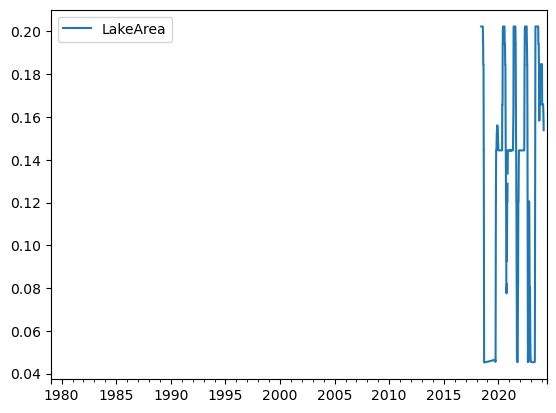

In [58]:
# This can be implemented in the add variable function of the CreateDataFile class
Tindx = pd.DatetimeIndex(sdset.time.values)
test = LAkm.reindex(pd.MultiIndex.from_product([Tindx, LAkm.index.levels[1]]))

test.xs('120031076', level='nhd_id').plot()

In [67]:
Ldep = calc_lake_depth(LA['LakeArea'], resdata['Storage_acreft'])
Ldep

datetime    nhd_id  
2016-11-08  71772901         NaN
2016-11-09  71772901    8.439671
2016-11-10  71772901    8.442256
2016-11-11  71772901    8.447341
2016-11-12  71772901    8.452314
                          ...   
2024-02-20  71818121         NaN
2024-02-21  71818121         NaN
2024-02-22  71818121         NaN
2024-02-23  71818121         NaN
2024-02-24  71818121         NaN
Length: 13325, dtype: float64

In [27]:
sdset

<xarray.Dataset>
Dimensions:   (time: 16593, location: 5)
Coordinates:
    lat       (location) float64 44.56 44.59 44.63 44.5 44.53
    lon       (location) float64 -107.2 -107.3 -107.3 -107.2 -107.2
    elev      (location) float64 2.518e+03 2.659e+03 ... 2.746e+03 2.664e+03
  * location  (location) object '71772129' '71759808' ... '120031076' '71772901'
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2024-06-05
Data variables:
    precip    (time, location) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    min_temp  (time, location) float32 240.8 240.8 240.8 ... 276.0 275.8 276.0
    max_temp  (time, location) float32 252.2 252.2 252.2 ... 287.7 287.0 287.7
    solrad    (time, location) float32 83.2 83.2 83.2 92.1 ... 186.0 194.0 186.0
    min_rh    (time, location) float32 46.5 46.5 46.5 47.6 ... 39.0 39.3 39.0
    max_rh    (time, location) float32 74.7 74.7 74.7 77.1 ... 80.5 80.1 80.5
    wind_dir  (time, location) float32 310.0 310.0 310.0 ... 352.0 352.0 352.0
    wind_vel  (time, location) float32 10.6 10.6 10.6 12.9 ... 3.2 3.2 3.1 3.2
Attributes:
    featureType:  timeSeries

In [6]:
from prep.utils import get_gridmet_cells

lakes = gpd.read_file(r'D:\ArcGIS_Projects\Yellowstone\Tongue River\Vector\HWWY_reservoirs_5070.shp')

CRSError: Invalid projection: epsg:5070: (Internal Proj Error: proj_create: SQLite error on SELECT name, coordinate_system_auth_name, coordinate_system_code, geodetic_crs_auth_name, geodetic_crs_code, conversion_auth_name, conversion_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM projected_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

In [3]:
lakes

NameError: name 'lakes' is not defined